
# Introduction

This notebook is a project about identifying Oku Hanako's music styles by grouping her songs that are played in a similar way or similar style.
The similarity will be determined by comparing songs based on their audio features from Spotify.
The data used in this notebook were obtained using the code in [/common/get_Spotify_audio_features.ipynb](https://github.com/edwardthezeroth/data-projects/blob/master/common/get_Spotify_audio_features.ipynb)

In [0]:
# Suppress output of this cell
%%capture

"""Install and import dependencies."""
# Import numpy to help with plots
import numpy as np

# Import pandas for dataframes
import pandas as pd 

# Install and import pandas profiling for better data summarisation
!pip install pandas-profiling

import pandas_profiling

# Import matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline 

# Import PCA for finding principal components
from sklearn.decomposition import PCA

# Import scikit-learn for scaling and k-means clustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [2]:
"""Set up connection to Google Drive."""

# import Drive helper and mount drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
"""Define paths and load file audio features"""

# Main path in Google Drive
home_path = '/content/drive/My Drive/Colab Notebooks'

# Path to save data
data_path = f'{home_path}/Data/Spotify audio features'

# File name
save_file_name = 'oku_hanako_audio_features.csv'

# Load file
all_songs_features = pd.read_csv(f'{data_path}/{save_file_name}')

# This command won't work until the pip installation is updated
#all_songs_features.drop(['album', 'track', 'track_id'], axis=1).profile_report(style={'full_width':True})

#pandas_profiling.ProfileReport(all_songs_features)

all_songs_features.drop(['album', 'track', 'track_id'], axis=1).describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000
mean,0.743738,0.514996,297460.156134,0.355054,0.059672,4.836431,0.143045,-8.958569,0.921933,0.030319,102.064840,3.981413,0.413611
std,0.245904,0.101110,44680.873209,0.165996,0.209257,3.052283,0.089277,2.317070,0.268777,0.005027,33.134268,0.160539,0.170933
min,0.001290,0.264000,90680.000000,0.021500,0.000000,0.000000,0.043100,-17.103000,0.000000,0.022500,60.688000,3.000000,0.048200
25%,0.675000,0.452000,274067.000000,0.229000,0.000004,2.000000,0.095800,-10.465000,1.000000,0.026800,77.074000,4.000000,0.279000
50%,0.829000,0.513000,297213.000000,0.329000,0.000038,5.000000,0.116000,-8.636000,1.000000,0.029000,82.464000,4.000000,0.392000
75%,0.922000,0.580000,323973.000000,0.452000,0.000570,7.000000,0.158000,-7.386000,1.000000,0.033000,130.093000,4.000000,0.517000
max,0.988000,0.841000,401720.000000,0.799000,0.964000,11.000000,0.692000,-3.800000,1.000000,0.048400,199.712000,5.000000,0.902000


# Feature Selection and Engineering

A description of the audio features is documented by [Spotify](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/).
Some of the audio features will be removed because they do not relate to music style.

* remove duration - music style is about how the music is played, not how long it is played
* remove acousticness and instrumentalness - the music for a particular song should be played roughly the same way regardless of whether the music is being played with acoustic instruments or with or without the lyrics being sung. 
The music may sound different, but the underlying musical score should be the same.
* remove liveliness - an artist may perform a song very differently in the presence of a live audience.
Fortunately, any live versions are clearly marked in Oku Hanako's albums, so it is not necessary to keep this feature for identifying live performances.
* remove speechiness - because these songs contain singing, not talking or rap


The key or pitch class is [represented with numbers](https://en.wikipedia.org/wiki/Pitch_class#Other_ways_to_label_pitch_classes). 
Successive tones are one semitone apart, and the tone returns to the same class every 12 semitone increments.
Due to the cyclical nature of this labelling system, it would be more appropriate to treat the key as a categorical variable instead of a continuous variable.
One-hot encoding will thus be applied so that the key is represented more appropriately.

The numerical audio features have values between 0 and 1 except for loudness, tempo, and time signature.
These loudness and tempo will be transformed so that their scale is similar to the other numerical features.
The time signature values range from 3 to 5, so the scale is still similar to the other features that are between 0 and 1.
This is important to avoid putting undue high importance on features with larger scales in later steps (clustering and dimension reduction) .

In [4]:
"""Keep selected features"""

# Specify features to keep
columns_to_keep = ['album', 'track'
                   , 'danceability'
                   , 'energy'
                   , 'key'
                   , 'loudness'
                   , 'mode'
                   , 'tempo'
                   , 'time_signature'
                   , 'valence'
                  ]

# Keep selected features
selected_songs_features = all_songs_features[columns_to_keep]

selected_songs_features.head(3)

,album,track,danceability,energy,key,loudness,mode,tempo,time_signature,valence
0,Kasumisou,Kaban no Naka no Yakimochi,0.535,0.323,5,-7.980,1,78.248,4,0.339
1,Kasumisou,Hontowane,0.378,0.473,5,-8.124,1,175.899,4,0.572
2,Kasumisou,Aenakutemo,0.361,0.207,11,-12.718,1,81.101,4,0.335


In [5]:
def one_hot_encode_key(df):
  """
  One-hot encode key with useful column names
  
  Args:
      df: The dataframe with the key column
      
  Returns:
      A dataframe with the key one-hot encoded with useful column names
  """
  
  # Define the key dictionary
  key_dict = {
      0: "C",
      1: "C_sharp",
      2: "D",
      3: "D_sharp",
      4: "E",
      5: "F",
      6: "F_sharp",
      7: "G",
      8: "G_sharp",
      9: "A",
      10: "A_sharp",
      11: "B"
  }
  
  # Convert the numerical representation of key to letters
  df_key_described = df.replace({"key": key_dict})
  
  # One-hot encode key
  key_one_hot = pd.get_dummies(df_key_described['key'])
  
  # Join the encoding to the dataframe
  df_joined_encoding = df_key_described.join(key_one_hot)
  
  # Drop key
  encoded_df = df_joined_encoding.drop('key', axis=1)
  
  return encoded_df


""" Apply one hot encoding function """
encoded_df = one_hot_encode_key(selected_songs_features)
encoded_df.head(3)

,album,track,danceability,energy,loudness,mode,tempo,time_signature,valence,A,A_sharp,B,C,C_sharp,D,D_sharp,E,F,F_sharp,G,G_sharp
0,Kasumisou,Kaban no Naka no Yakimochi,0.535,0.323,-7.980,1,78.248,4,0.339,0,0,0,0,0,0,0,0,1,0,0,0
1,Kasumisou,Hontowane,0.378,0.473,-8.124,1,175.899,4,0.572,0,0,0,0,0,0,0,0,1,0,0,0
2,Kasumisou,Aenakutemo,0.361,0.207,-12.718,1,81.101,4,0.335,0,0,1,0,0,0,0,0,0,0,0,0


In [6]:
# Define columns to scale
minmax_cols = ['tempo', 'loudness']

# Initialise min max scaler
minmax_scaler = MinMaxScaler()

# Train the min max scaler on the selected columns
minmax_scaler.fit(encoded_df[minmax_cols])

# Apply the min max scaler
encoded_df[minmax_cols] = minmax_scaler.transform(encoded_df[minmax_cols])


encoded_df.head(3)

,album,track,danceability,energy,loudness,mode,tempo,time_signature,valence,A,A_sharp,B,C,C_sharp,D,D_sharp,E,F,F_sharp,G,G_sharp
0,Kasumisou,Kaban no Naka no Yakimochi,0.535,0.323,0.685785,1,0.126309,4,0.339,0,0,0,0,0,0,0,0,1,0,0,0
1,Kasumisou,Hontowane,0.378,0.473,0.674961,1,0.828713,4,0.572,0,0,0,0,0,0,0,0,1,0,0,0
2,Kasumisou,Aenakutemo,0.361,0.207,0.329625,1,0.146831,4,0.335,0,0,1,0,0,0,0,0,0,0,0,0


# Initial plot

In [7]:
def apply_pca(df, feature_cols, num_pc):
  """
  Apply PCA to find num_pc principal components in the input df,
  and returns the df with the principal components attached.

  Args:
      df: The dataframe of input features
      feature_cols: The list of names of columns containing the features
      num_pc: The integer number of principal components to find

  Returns:
      A dataframe of the input df with the principal component coordinates attached.
  """

  # Keep only the feature columns
  feature_df = df[feature_cols]
  
  # Set up PCA transformer 
  pca = PCA(n_components=num_pc)
  pca.fit(feature_df)
  
  # Find the principal components
  identified_pc = pca.transform(feature_df)
  
  # Attach the principal components to the input df
  df_with_pc = pd.DataFrame(np.concatenate([df, identified_pc], axis=1))

  return df_with_pc


""" Apply PCA function """
# List of feature columns
feature_cols = ['danceability','energy','loudness','mode','tempo','time_signature','valence',
                'A','A_sharp','B','C','C_sharp','D','D_sharp','E','F','F_sharp','G','G_sharp']

# Apply PCA
df_with_pc = apply_pca(encoded_df, feature_cols, 2)
df_with_pc.columns = ['album', 'track'] + feature_cols + ['component_1', 'component_2']
df_with_pc.head(3)

,album,track,danceability,energy,loudness,mode,tempo,time_signature,valence,A,A_sharp,B,C,C_sharp,D,D_sharp,E,F,F_sharp,G,G_sharp,component_1,component_2
0,Kasumisou,Kaban no Naka no Yakimochi,0.535,0.323,0.685785,1,0.126309,4,0.339,0,0,0,0,0,0,0,0,1,0,0,0,-0.298105,0.643764
1,Kasumisou,Hontowane,0.378,0.473,0.674961,1,0.828713,4,0.572,0,0,0,0,0,0,0,0,1,0,0,0,-0.275876,0.643585
2,Kasumisou,Aenakutemo,0.361,0.207,0.329625,1,0.146831,4,0.335,0,0,1,0,0,0,0,0,0,0,0,0,-0.0781859,-0.00566134


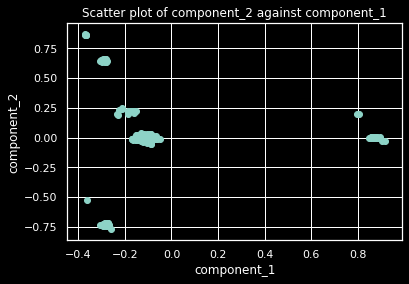

In [9]:
def scatter_plot(df, x_col, y_col):
  """
  Create a scatter plot.

  Args:
      df: The dataframe with input data
      x_col: The name of the column to put on the x-axis
      y_col: The name of the column to put on the y-axis

  Returns:
      No output.
  """
  
  # Create x and y vectors
  x = df[x_col]
  y = df[y_col]

  # Co-lab notebook in dark mode
  plt.style.use(['dark_background'])

  plt.scatter(x, y)
  plt.title(f'Scatter plot of {y_col} against {x_col}')
  plt.xlabel(x_col)
  plt.ylabel(y_col)
  plt.show()

  return None


x_col = 'component_1'
y_col = 'component_2'

# Create scatter plot
scatter_plot(df_with_pc, x_col, y_col)

# Find the number of clusters

In [10]:
def apply_kmeans(df, feature_cols, num_clusters):
  """
  Use k-means to assign each item to a cluster, and returns the
  input with the cluster ID attached.

  Args:
      df: The dataframe of input features
      feature_cols: The list of names of columns containing the features
      num_clusters: The number of clusters to try to find

  Returns:
      A dataframe of the input df with the cluster IDs attached.
  """
  # Convert DataFrame to numpy array
  data_array = df[feature_cols].values
  
  kmeans_fit = KMeans(n_clusters=num_clusters, random_state=0)

  labels = kmeans_fit.fit(data_array).labels_
  centre_labels = kmeans_fit.fit_predict(data_array)
  centres = kmeans_fit.cluster_centers_
  
  # Attach cluster labels to original dataframe
  df['cluster_id'] = labels
    
  return df


df_with_cid = apply_kmeans(df_with_pc, feature_cols, 4)
df_with_cid.head(3)

,album,track,danceability,energy,loudness,mode,tempo,time_signature,valence,A,A_sharp,B,C,C_sharp,D,D_sharp,E,F,F_sharp,G,G_sharp,component_1,component_2,cluster
0,Kasumisou,Kaban no Naka no Yakimochi,0.535,0.323,0.685785,1,0.126309,4,0.339,0,0,0,0,0,0,0,0,1,0,0,0,-0.298105,0.643764,3
1,Kasumisou,Hontowane,0.378,0.473,0.674961,1,0.828713,4,0.572,0,0,0,0,0,0,0,0,1,0,0,0,-0.275876,0.643585,3
2,Kasumisou,Aenakutemo,0.361,0.207,0.329625,1,0.146831,4,0.335,0,0,1,0,0,0,0,0,0,0,0,0,-0.0781859,-0.00566134,2


# Remove Duplicates

Some songs appear multiple times in different albums and singles as shown by the shared track name.
Besides that, some songs have different versions as indicated in the track name.

To simplify the decision about whether different versions of the same song are duplicates or not, this part of the project will only consider the base version of each song.

In [0]:
# Count the number of times a track appears
num_track_appearances = all_songs_features \
    .groupby('track') \
    .count() \
    [['track_id']] \
    .rename(columns = {'track_id': 'number_of_tracks'})

# Show sample of tracks where the name appears more than once
num_track_appearances \
.sort_values(by=['number_of_tracks'], ascending=False) \
.head(5)
#.loc[num_track_appearances['number_of_tracks'] > 1]

,number_of_tracks
track,
Tegami,4
Yasashii Hana,4
Happy Days,4
Kimi no Egao,4
Waratte Waratte,4


In [0]:
# Show an example of a track with multiple versions
all_songs_features.loc[(all_songs_features['track'].str.contains('Garnet'))]

,album,track,track_id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
29,Time Note,Garnet (Hikigatari),5hu1dBV5JKRU6gUnZpOJ1Y,0.929,0.614,311587,0.236,0.000000,3,0.201,-10.005,1,0.0347,72.688,4,0.517
110,Hanako Oku Best ~ My Letters ~,Garnet,40jwSjLscs3wDOvYUpaJoB,0.753,0.515,320493,0.355,0.000176,3,0.129,-8.360,1,0.0283,73.643,4,0.362
202,Garnet,Garnet - Hikigatari,6rXPX0WpTKNGAOAoLPcF8Q,0.923,0.601,316280,0.251,0.000012,3,0.230,-10.281,1,0.0330,72.921,4,0.493
204,Garnet,Garnet,2rZUu2qXb7SoUNktHKgfky,0.790,0.510,319067,0.353,0.000278,3,0.148,-8.399,1,0.0292,73.565,4,0.318
240,Hatsukoi,Garnet - Live Ver.,5u0psQQOoq6CA5E8RqsWmE,0.899,0.390,348733,0.255,0.000270,10,0.676,-9.847,1,0.0335,74.362,4,0.279


In [0]:


"""

1. feature selection
-- remove duration because how the music is played should be independent of the track length
-- remove liveliness. Although a live performance may be played differently, it is still mostly the same song
-- remove speechiness because there is no need to evaluate how much speaking occurs in the songs


2. feature engineering
-- encode key: treat it as categorical instead of numerical


3. PCA and plot
-- https://www.kdnuggets.com/2019/01/dimension-reduction-data-science.html


4. clustering k-means with number of clusters evaluation
-- try other clustering methods
-- https://www.kdnuggets.com/2018/06/5-clustering-algorithms-data-scientists-need-know.html
-- https://www.kdnuggets.com/2019/10/clustering-metrics-better-elbow-method.html


1. remove duplicates
-- try using all tracks first, then try removing duplicates and see whether the results change


6. Publish results on a Tableau public dashboard for others to play with
--
"""